In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure 

keras = tf.keras

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
def plot_series(time, series, std_dev, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time (sec)")
    plt.ylabel("SINR (dB)")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    #plt.xlim([0, time.size])
    plt.title("SINR for a UE w.r.t diff BS (std dev = {}dB)".format(std_dev))

In [7]:
def window_dataset(series, window_size, batch_size=32,                          
                   shuffle_buffer=1000):                                         
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))    
    dataset = dataset.shuffle(shuffle_buffer)                                   
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))             
    dataset = dataset.batch(batch_size).prefetch(1)                             
    return dataset

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Input the SINR Time-series

In [9]:
#series_21 = np.loadtxt('/content/user_2000.csv', delimiter=',')
#series_21 = np.loadtxt('user_sinr_shad_stdev4.csv', delimiter=',')
series_21 = np.loadtxt('sinr_correl_shad8dB_10k.csv', delimiter=',')
#series_21 = sinr_all2[:TIME_INST,0:21, 2]
series_csv = pd.read_csv('sinr_correl_shad6dB_2k.csv')

print(np.shape(series_21))
time = np.arange(len(series_21))
total_time_steps = len(series_21)

print(np.shape(time))

(10000, 21)
(10000,)


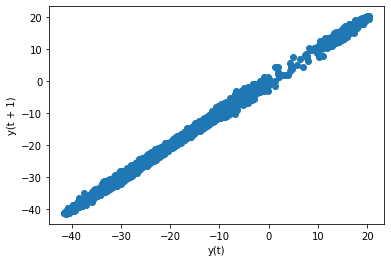

In [10]:
from pandas.plotting import lag_plot
lag_plot(series_csv[:1000])
plt.show()

In [11]:
srs = series_21[:4000,0]
#print(srs)
srs = np.reshape(srs, (-1,1))
#print(srs.shape)
#print(srs)


In [12]:
series = srs
print(np.shape(series))
series = series.flatten()
print(series.shape)

time = np.arange(len(series))
total_time_steps = len(series)

(4000, 1)
(4000,)


In [13]:
#Creating Train - Validation Split
split_ratio =  0.8
split_time = int (split_ratio*total_time_steps)
time_train = time[:split_time] +1
x_train = series[:split_time]
time_valid = time[split_time:] +1
x_valid = series[split_time:]


In [14]:
print("Train time:{}\nValidation Time: {}".format(len(time_train), len(time_valid)))

Train time:3200
Validation Time: 800


In [15]:
print("Training data: \n", x_train ,"\t", time_train)
print("\n")
#print("Validation data: \n", x_valid ,"\t", time_valid)

Training data: 
 [ 17.15102237  17.04826565  16.31781888 ... -38.33600238 -37.99785656
 -38.9645008 ] 	 [   1    2    3 ... 3198 3199 3200]




# AUTOREGRESSIVE MODEL

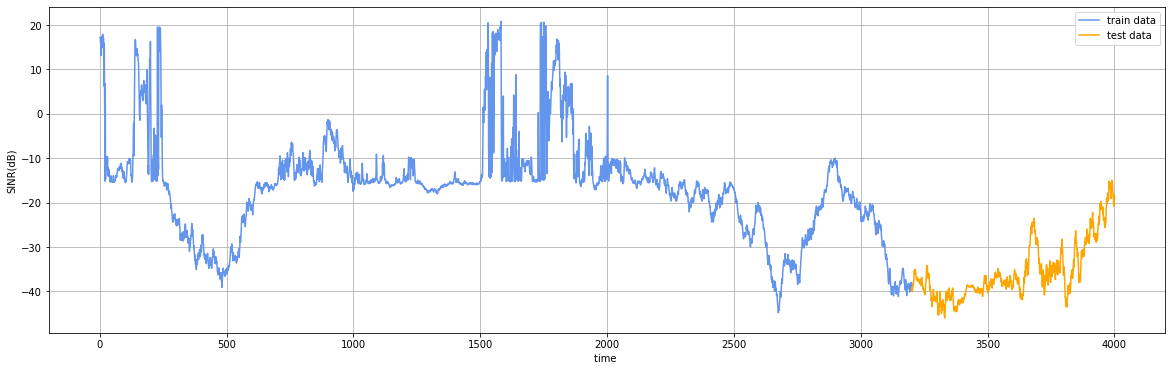

In [16]:
plt.figure(figsize=(20, 6))
plt.plot(time_train, x_train, color='cornflowerblue', label='train data')
plt.plot(time_valid, x_valid, color='orange', label='test data')
plt.legend()
plt.xlabel("time ")
plt.ylabel("SINR(dB)")
plt.grid()
plt.show()

In [13]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(x_train, lags= 700) 
trained_model = model.fit()
# print('Coefficients: %s' % trained_model.params)

In [14]:
print('Coefficients: %s' % trained_model.params)

Coefficients: [-1.04991705e-01  7.29437612e-01  1.79918864e-02  1.47369310e-01
  1.85090747e-02 -8.87333178e-02  1.26105423e-01  1.35941588e-01
 -4.94376009e-02 -1.21509553e-01  8.37514429e-02 -2.78857812e-02
 -3.02947308e-02  3.45676335e-02  2.98705072e-02 -8.71211470e-02
  1.32083122e-01 -1.15096211e-01  3.26580223e-02  9.19106879e-02
  4.20428167e-02 -1.39949225e-01  5.35876980e-02 -9.66509731e-02
  6.14009065e-02  1.53053171e-02 -6.10081875e-02  6.22972844e-03
  1.08851563e-01 -8.40888556e-02  8.91436781e-03  1.13289775e-01
 -1.41093265e-01  7.74543539e-02 -6.81348623e-02 -4.05298913e-02
  5.26065416e-02  4.00885469e-02 -8.41060413e-02  3.85788984e-02
  4.69355309e-03  3.72075155e-02 -3.25697541e-02  4.45884681e-02
 -7.93450465e-02  7.30059898e-02  1.82756903e-02 -6.58576783e-02
  4.03564960e-03  1.09819618e-01 -2.85667140e-02  6.99495405e-02
 -2.69817936e-02 -6.98238373e-02  5.04646672e-02 -3.41444151e-02
 -8.24486769e-02  2.50542469e-02 -2.05581538e-02  1.89099286e-02
  2.4996768

In [15]:
predictions = trained_model.predict(start=len(x_train), 
                                    end= len(x_train) + len(x_valid) - 1)

error = mean_squared_error(x_valid, predictions, squared= False)

print(f'RMSE for AR Model: {error:.3}')


RMSE for AR Model: 9.32


In [16]:
print(x_valid.shape, predictions.shape)

(800,) (800,)


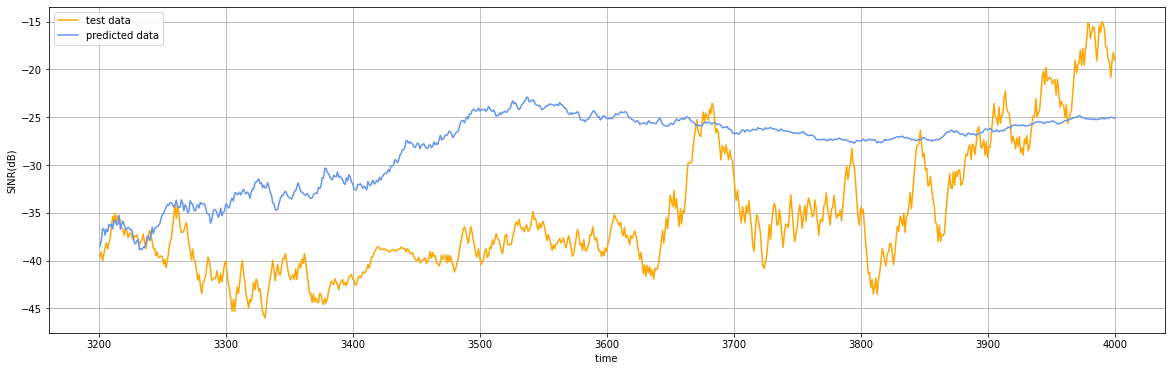

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(time_valid, x_valid, color='orange', label='test data')
plt.plot(time_valid, predictions, color='cornflowerblue', label='predicted data')

plt.legend()
plt.xlabel("time ")
plt.ylabel("SINR(dB)")
plt.grid()
plt.show()

10k time steps

training points-------label-------

1-9000 9001 \
2-9001 9002 \
3-9002 9003 

# Walk Forward Auto-Regressive Model

Test RMSE: 1.048


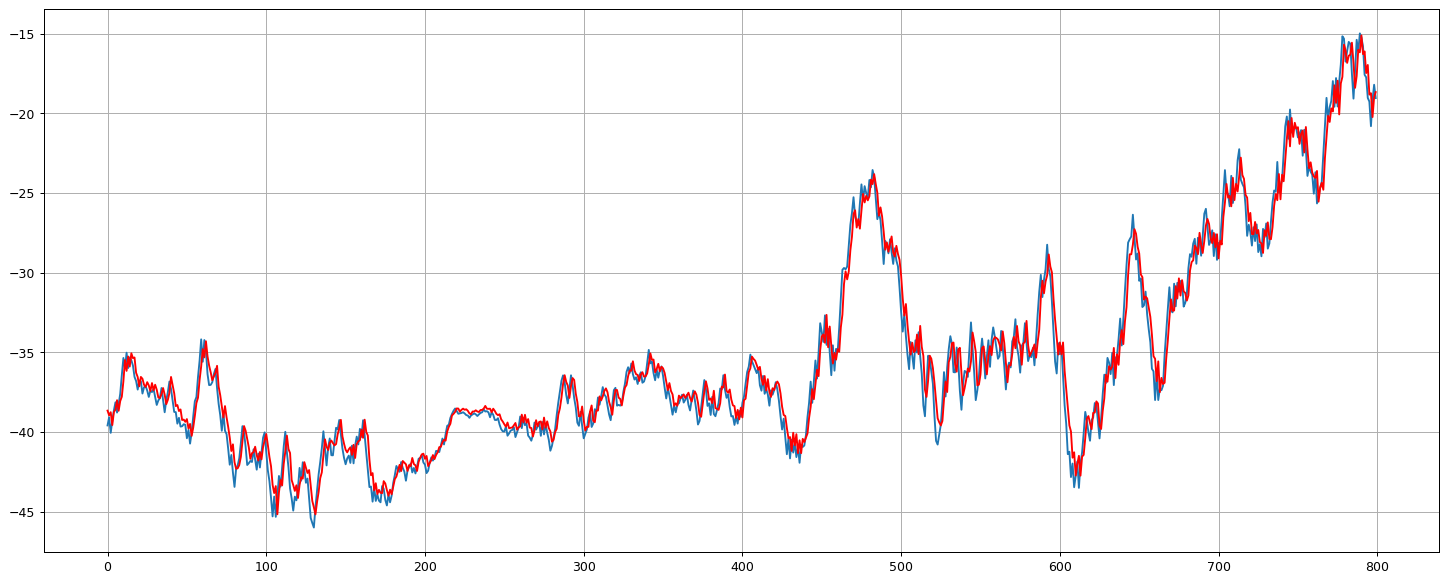

In [18]:
from math import sqrt
window = 30
model = AutoReg(x_train, lags=30)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = x_train[len(x_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(x_valid)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = x_valid[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(x_valid, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
figure(figsize=(20, 8), dpi=90)
plt.plot(x_valid)
plt.plot(predictions, color='red')
plt.grid()
plt.show()

In [19]:
predictions_ar = np.copy(predictions_ar)
print(predictions_ar.shape)

NameError: name 'predictions_ar' is not defined

NameError: name 'predictions_ar' is not defined

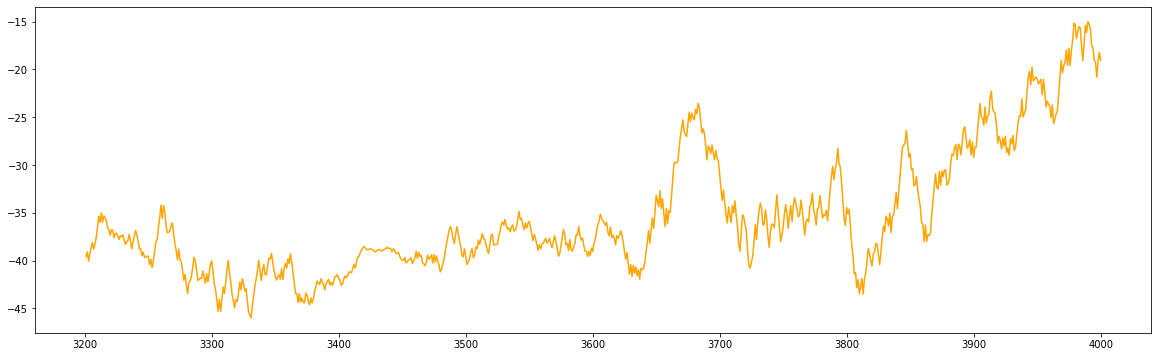

In [20]:
plt.figure(figsize=(20, 6))
plt.plot(time_valid, x_valid, color='orange', label='test data')
plt.plot(time_valid, predictions_ar, color='cornflowerblue', label='predicted data')

plt.legend()
plt.xlabel("time ")
plt.ylabel("SINR(dB)")
plt.grid()
plt.show()

# MOVING AVERAGE MODEL

In [17]:
def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [18]:
moving_avg_pred = moving_average_forecast(series, 30)[split_time - 30:]


In [19]:
moving_avg_pred.shape

(800,)

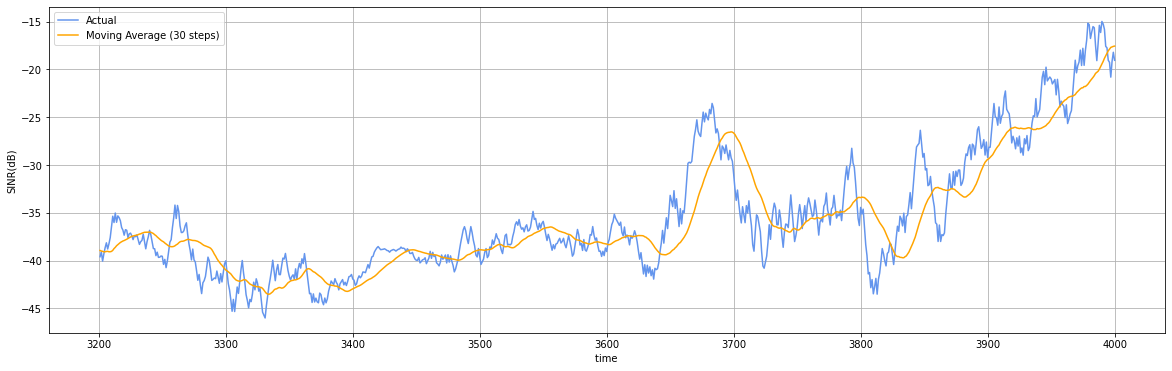

In [20]:
plt.figure(figsize=(20, 6))
#plt.plot(series, color='orange', label='test data')
plt.plot(time_valid, x_valid, color='cornflowerblue', label='Actual')
plt.plot(time_valid, moving_avg_pred, color='orange', label='Moving Average (30 steps)')

plt.legend()
plt.xlabel("time ")
plt.ylabel("SINR(dB)")
plt.grid()
plt.show()

In [21]:
ma_rmse_error = mean_squared_error(x_valid, moving_avg_pred, squared= False)
ma_mae_error = mean_absolute_error(x_valid, moving_avg_pred)

In [22]:
print(f'RMSE for Moving Average: {ma_rmse_error:.4f}')
print(f'MAE for Moving Average: {ma_mae_error:.4f}')

RMSE for Moving Average: 2.8545
MAE for Moving Average: 2.1421


# AutoRegressive Integrated Moving Average (ARIMA)

In [23]:
from statsmodels.tsa.arima.model import ARIMA


In [48]:
print(series.shape)

(2000,)


In [49]:
model = ARIMA(series, order=(5,1,0))

model_fit = model.fit()

#Model Summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1880.070
Date:                Wed, 09 Mar 2022   AIC                           3772.140
Time:                        15:19:12   BIC                           3805.743
Sample:                             0   HQIC                          3784.479
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0054      0.015      0.350      0.727      -0.025       0.035
ar.L2          0.0056      0.015      0.369      0.712      -0.024       0.035
ar.L3          0.0174      0.015      1.159      0.2

In [50]:
history = [x for x in series]

In [51]:
print(len(history))

2000


In [52]:
for t in range(2):
    #print(history[t: len(x_train)+t])
    print(t, len(x_train)+t)

0 1600
1 1601


In [60]:
# walk-forward validation
predictions = list()
window = 20
for t in range(len(x_valid)):
    model = ARIMA(history[len(x_valid)-20+t: len(x_train)+t], order=(5,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = x_valid[t]
    #history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts


In [61]:
predictions_arima = np.copy(predictions)
print(predictions_arima.shape)

(400,)


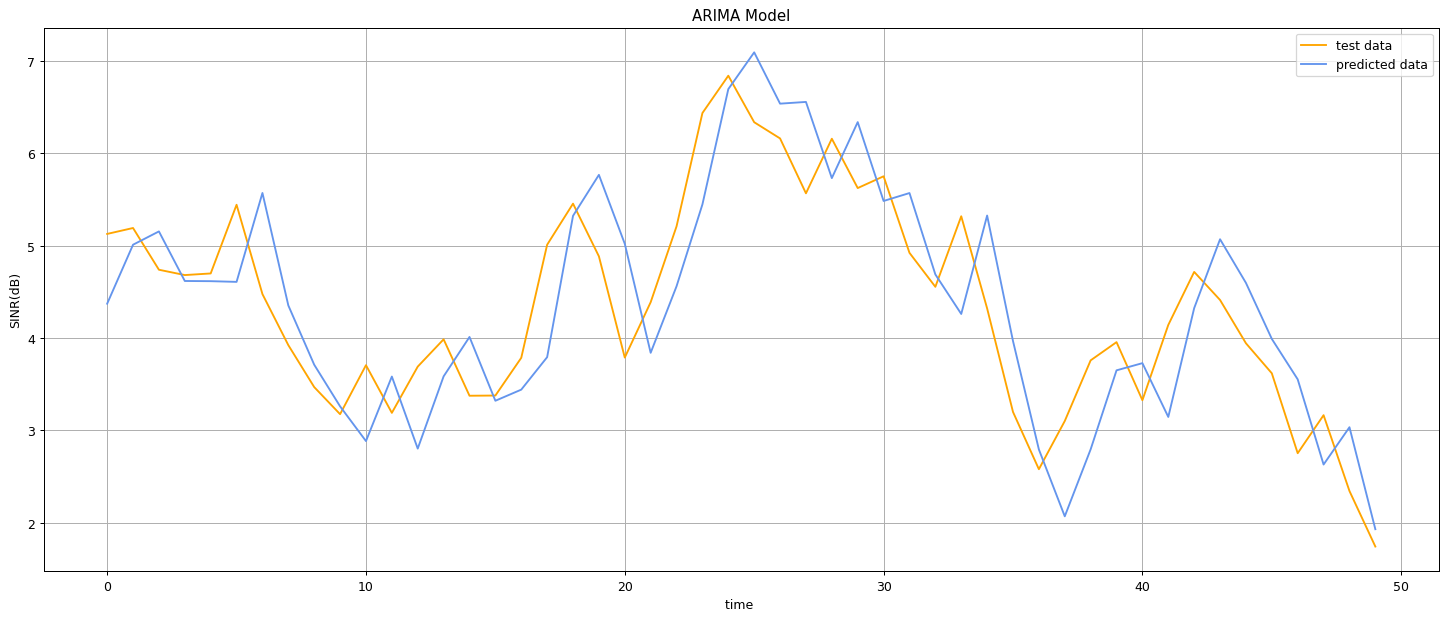

In [62]:
figure(figsize=(20, 8), dpi=90)
plt.plot(x_valid[:50], color='orange', label='test data')
plt.plot(predictions_arima[:50], color='cornflowerblue', label='predicted data')
plt.title('ARIMA Model')
plt.legend()
plt.xlabel("time ")
plt.ylabel("SINR(dB)")
plt.grid()
plt.show()

In [63]:
arima_rmse_error = mean_squared_error(x_valid, predictions_arima, squared= False)
arima_mae_error = mean_absolute_error(x_valid, predictions_arima)

In [64]:
print(f'RMSE for ARIMA: {arima_rmse_error:.4f}')
print(f'MAE for ARIMA: {arima_mae_error:.4f}')

RMSE for ARIMA: 0.6481
MAE for ARIMA: 0.5365


# Support Vector Regression (SVR)

In [24]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Preparing dataset for SVR Training

In [25]:
window_size = 10
train_set = window_dataset(x_train, window_size)

In [26]:
count=0
for x, y in train_set:
    print(x, y)
    count+=1
    break
    
print(count)

tf.Tensor(
[[-34.435083   -33.58188852 -33.37309909 -32.5767107  -31.43487922
  -30.25132741 -29.99393107 -29.98130767 -31.24070139 -30.6318357 ]
 [  9.89632383   6.01018048   1.20953772  -1.05629826  -7.34504861
  -13.36620518 -11.54905853 -13.64231255  -4.75615647   1.25093117]
 [-32.29238652 -32.18661521 -32.85671937 -33.88644315 -33.10246718
  -34.11974161 -34.52439411 -35.52778326 -35.46002719 -36.31226376]
 [-13.76077285 -13.96529795 -13.78072495 -14.93174471 -15.4275945
  -15.31607344 -14.66891683 -13.79046412  -9.09120857  -8.99527187]
 [-22.90411608 -23.45442795 -24.50973535 -23.833845   -23.32469186
  -22.5894413  -23.67723761 -23.58361889 -24.63656791 -24.55871504]
 [-17.10529792 -17.1161231  -16.92933653 -16.64919655 -16.43935998
  -16.24496871 -15.95229645 -15.70045979 -15.99391261 -16.0880811 ]
 [-36.32857476 -35.77672398 -37.05972622 -35.80230249 -37.08852049
  -37.55160758 -38.31384368 -39.10354616 -38.07973535 -36.81896323]
 [-29.14478313 -27.97177141 -29.22757082 -28.

In [27]:
type(train_set)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [28]:
#x

In [29]:
def window_dataset(series, window_size, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))    
    #dataset = dataset.shuffle(shuffle_buffer)                                   
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))             
    #dataset = dataset.batch(batch_size).prefetch(1)
    #dataset = dataset.prefetch(1)
    dataset = list(dataset) 
    x_train_dataset = []
    y_train_dataset = []

    for series in dataset:
        x_train_dataset.append(series[0])
        y_train_dataset.append(series[1])    
        
    x_train_dataset = np.array(x_train_dataset)
    y_train_dataset = np.array(y_train_dataset)
          
    return x_train_dataset, y_train_dataset

In [30]:
num = np.arange(1,101)

In [31]:
x_num, y_num = window_dataset(num, 10)

In [32]:
for x, y in zip(x_num, y_num):
    print(x,' ',y)
    break

[ 1  2  3  4  5  6  7  8  9 10]   11


## SVR Train-Test Split


In [68]:
#series_21 = np.loadtxt('/content/user_2000.csv', delimiter=',')
#series_21 = np.loadtxt('user_sinr_shad_stdev4.csv', delimiter=',')
series_21 = np.loadtxt('sinr_correl_shad8dB_10k.csv', delimiter=',')
#series_21 = sinr_all2[:TIME_INST,0:21, 2]
series_csv = pd.read_csv('sinr_correl_shad8dB_1k.csv')

print(np.shape(series_21))
time = np.arange(len(series_21))
total_time_steps = len(series_21)

print(np.shape(time))

(10000, 21)
(10000,)


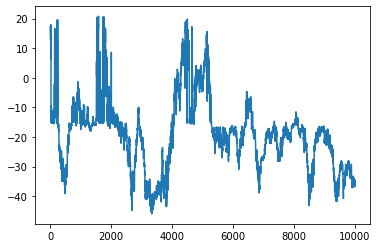

In [69]:
plt.plot(series_21[:,0])

In [70]:
svr_series = series_21[:,0]

In [71]:
window_size = 30

In [88]:
x_train, y_train = window_dataset(svr_series[:int(0.8*len(svr_series))], window_size)
x_test, y_test = window_dataset(svr_series[int(0.8*len(svr_series)):], window_size)

In [89]:
y_train.shape

(7970,)

In [90]:
y_test.shape

(1970,)

In [75]:
print(x_test)

[[-15.82014511 -15.79725293 -15.74709007 ... -15.99300539 -15.87699303
  -15.74822156]
 [-15.79725293 -15.74709007 -15.76301961 ... -15.87699303 -15.74822156
  -15.64348611]
 [-15.74709007 -15.76301961 -15.56078837 ... -15.74822156 -15.64348611
  -15.60698547]
 ...
 [-34.97782022 -34.22107023 -35.08069702 ... -34.79438464 -35.25810954
  -36.38801293]
 [-34.22107023 -35.08069702 -34.22294332 ... -35.25810954 -36.38801293
  -35.42180376]
 [-35.08069702 -34.22294332 -34.96241077 ... -36.38801293 -35.42180376
  -35.8532386 ]]


In [76]:
print(y_train)

[ -9.81760437 -13.05551245 -14.00542239 ... -15.78802232 -15.80354445
 -15.6309548 ]


# SVR TRAINING

In [42]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.001, epsilon=0.5)

In [43]:
print(x_train.shape, y_train.shape)

(770, 30) (770,)


In [44]:
svr_rbf.fit(x_train, y_train)

SVR(C=100, epsilon=0.5, gamma=0.001)

In [45]:
svr_prediction = svr_rbf.predict(x_test)

In [46]:
svr_prediction.shape

(170,)

In [47]:
y_test.shape

(170,)

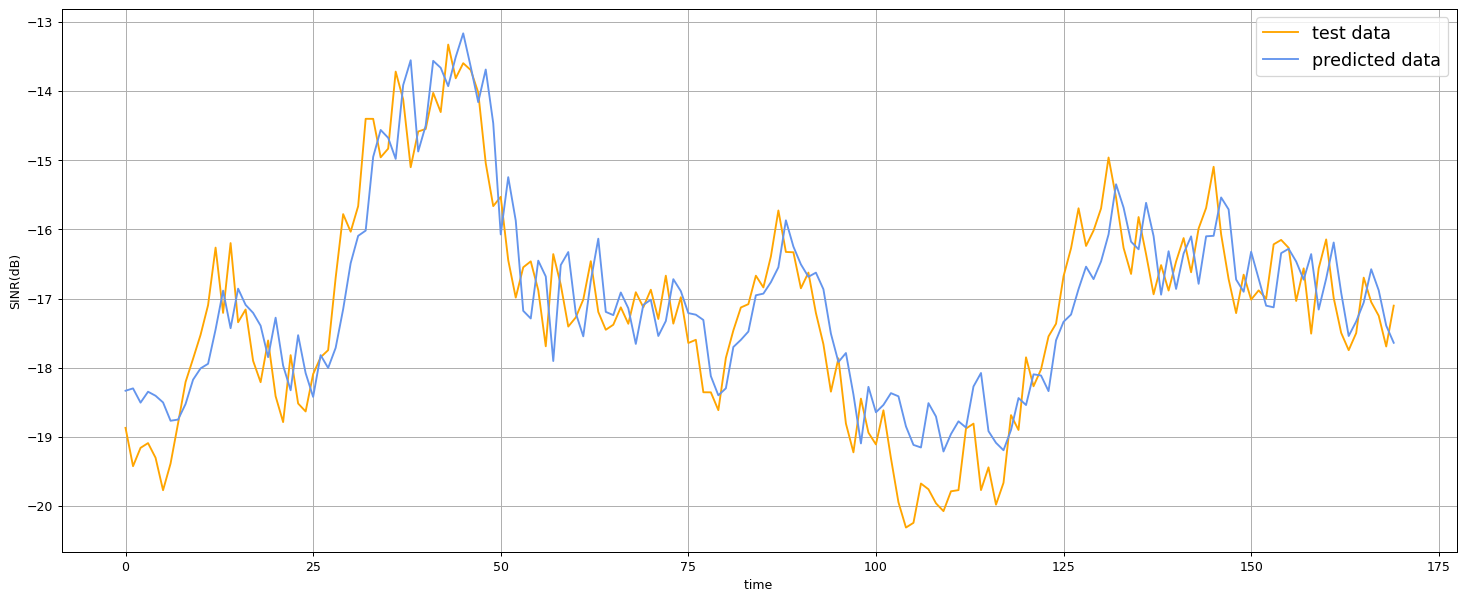

In [48]:
figure(figsize=(20, 8), dpi=90)
plt.plot(y_test, color='orange', label='test data')
plt.plot(svr_prediction, color='cornflowerblue', label='predicted data')

plt.legend(fontsize=14)
plt.xlabel("time ")
plt.ylabel("SINR(dB)")
plt.grid()
plt.show()

In [49]:
svr_rmse_error = mean_squared_error(y_test, svr_prediction, squared= False)
svr_mae_error = mean_absolute_error(y_test, svr_prediction)
print(f'RMSE for SVR: {svr_rmse_error:.4f}')
print(f'MAE for SVR: {svr_mae_error:.4f}')

RMSE for SVR: 0.7082
MAE for SVR: 0.5908


# Testing on Unknown Data

In [110]:
test_dt = np.loadtxt('sinr_correl_shad8dB_2k.csv', delimiter=',')
print(test_dt.shape)
test_data = test_dt[:,1]
print(test_data.shape)

(1000, 21)
(1000,)


In [111]:
testx, testy = window_dataset(test_data, window_size)

In [112]:
test_svr_pred = svr_rbf.predict(testx)

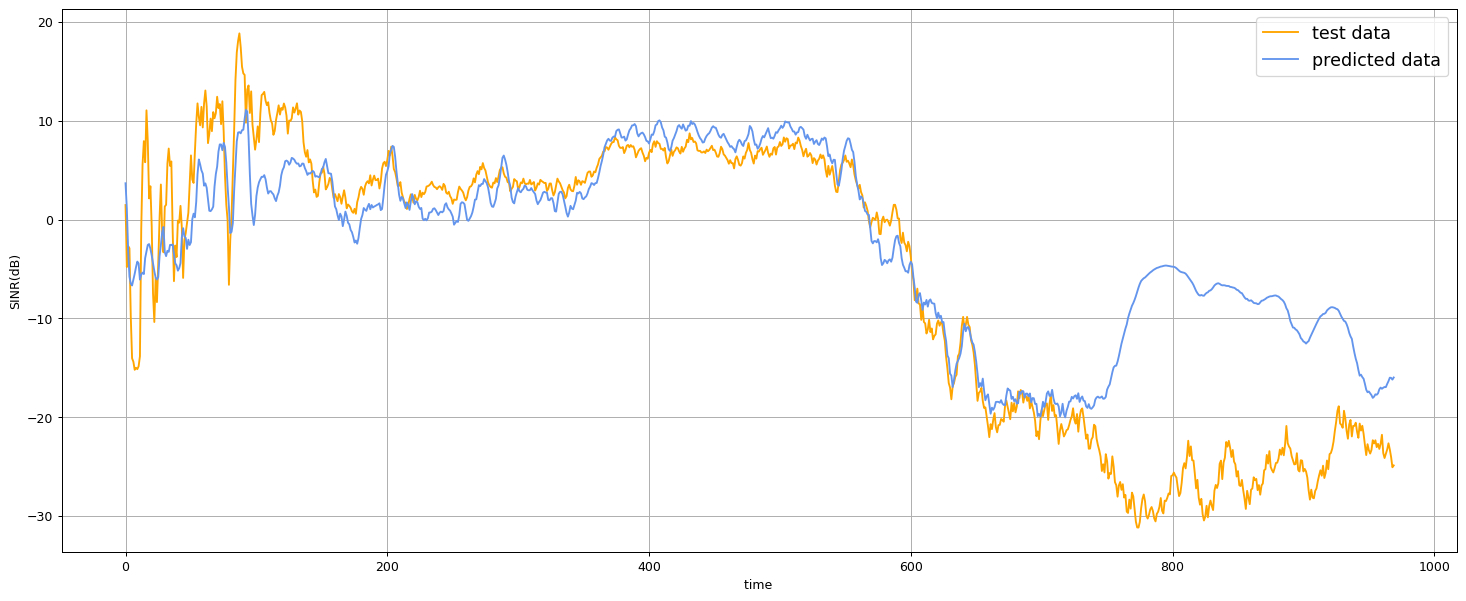

In [113]:
figure(figsize=(20, 8), dpi=90)
plt.plot(testy, color='orange', label='test data')
plt.plot(test_svr_pred, color='cornflowerblue', label='predicted data')

plt.legend(fontsize=14)
plt.xlabel("time ")
plt.ylabel("SINR(dB)")
plt.grid()
plt.show()

In [114]:
svr_rmse_error = mean_squared_error(testy, test_svr_pred, squared= False)
svr_mae_error = mean_absolute_error(testy, test_svr_pred)
print(f'RMSE for SVR: {svr_rmse_error:.4f}')
print(f'MAE for SVR: {svr_mae_error:.4f}')

RMSE for SVR: 8.5721
MAE for SVR: 5.5047


RMSE for SVR:  0.5453484797275809
MAE FOR SVR: 0.41283418628885965


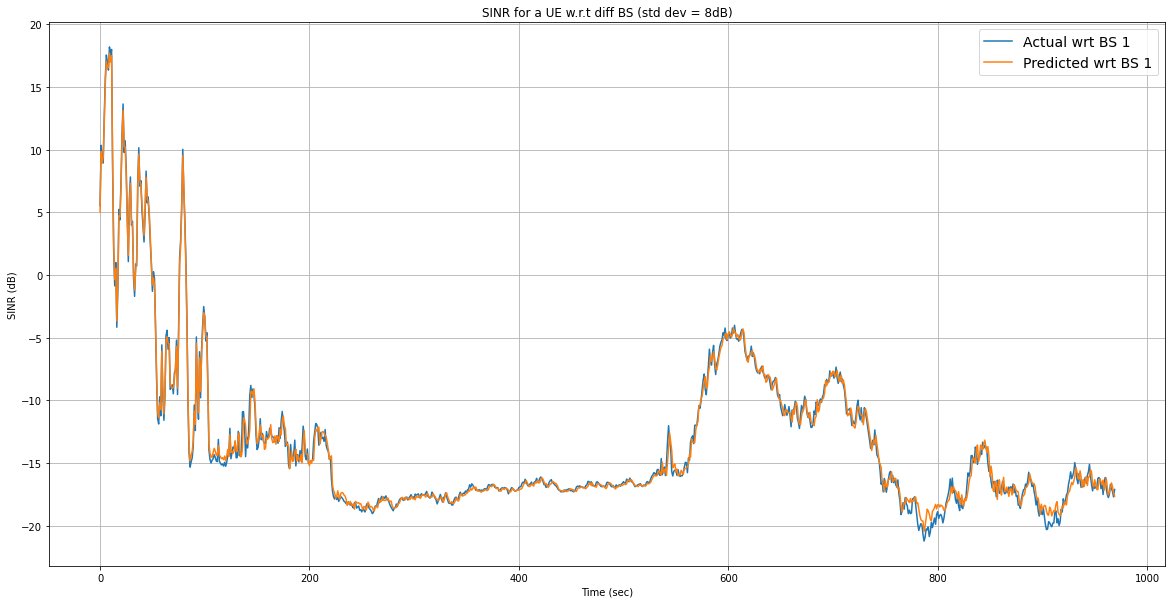

RMSE for SVR:  8.57208383371304
MAE FOR SVR: 5.504737433788438


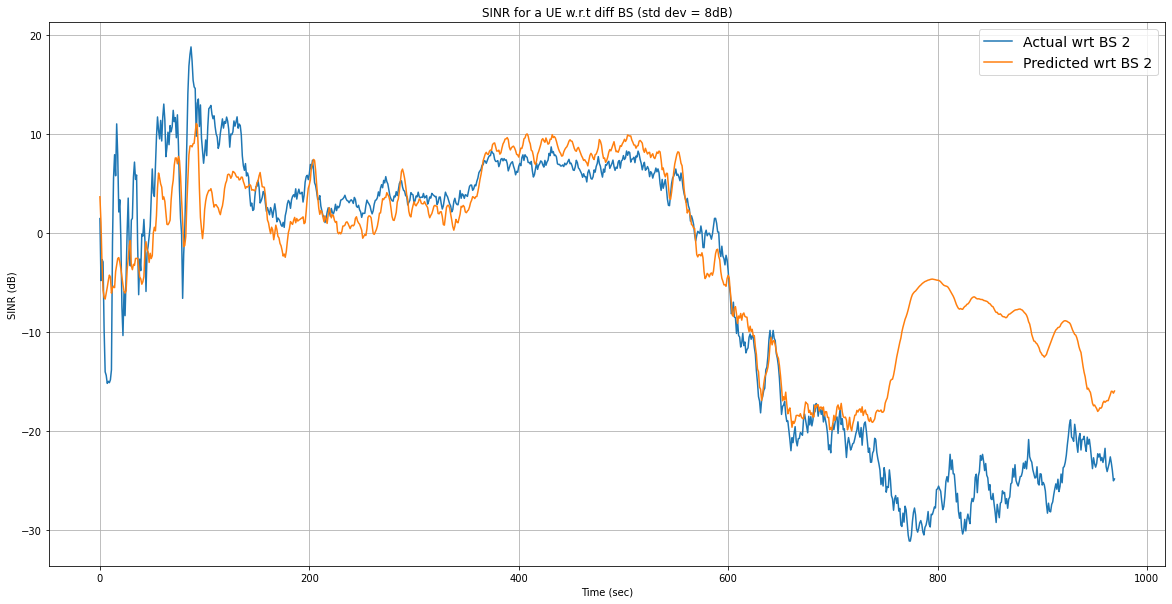

RMSE for SVR:  14.471024737601596
MAE FOR SVR: 8.318717200294898


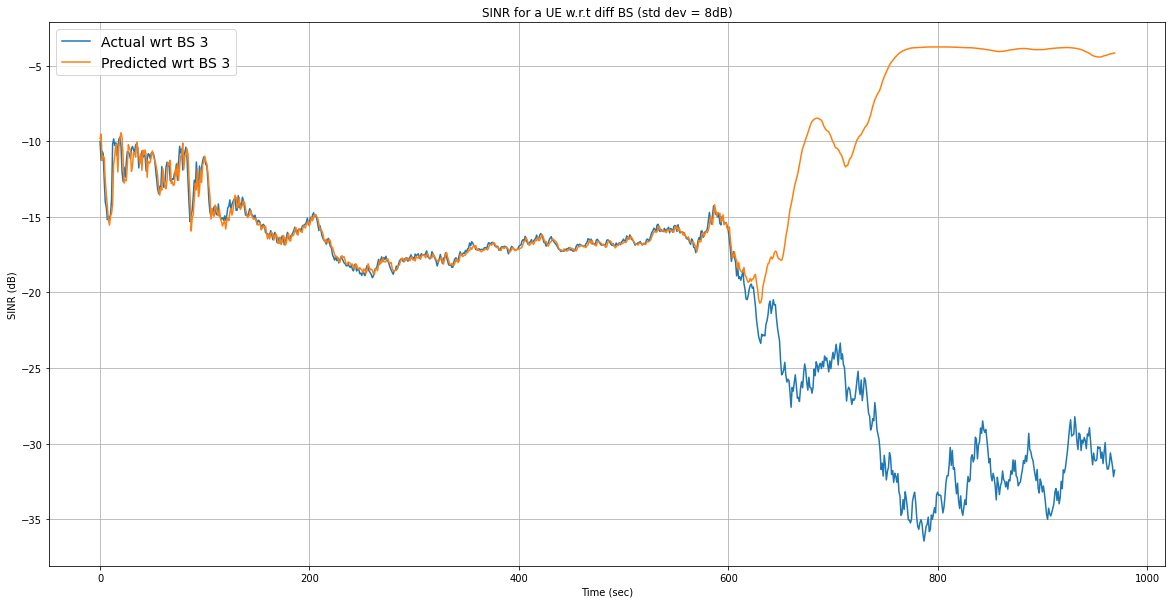

RMSE for SVR:  3.4876818822529807
MAE FOR SVR: 1.318747364696534


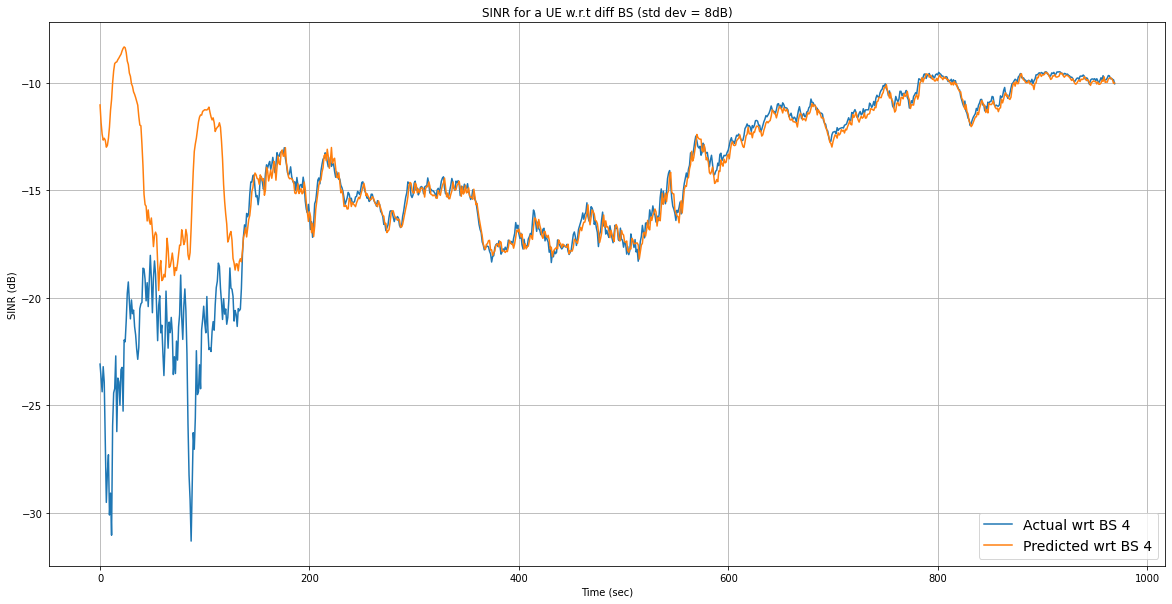

RMSE for SVR:  2.9089159862592515
MAE FOR SVR: 1.4795395324906404


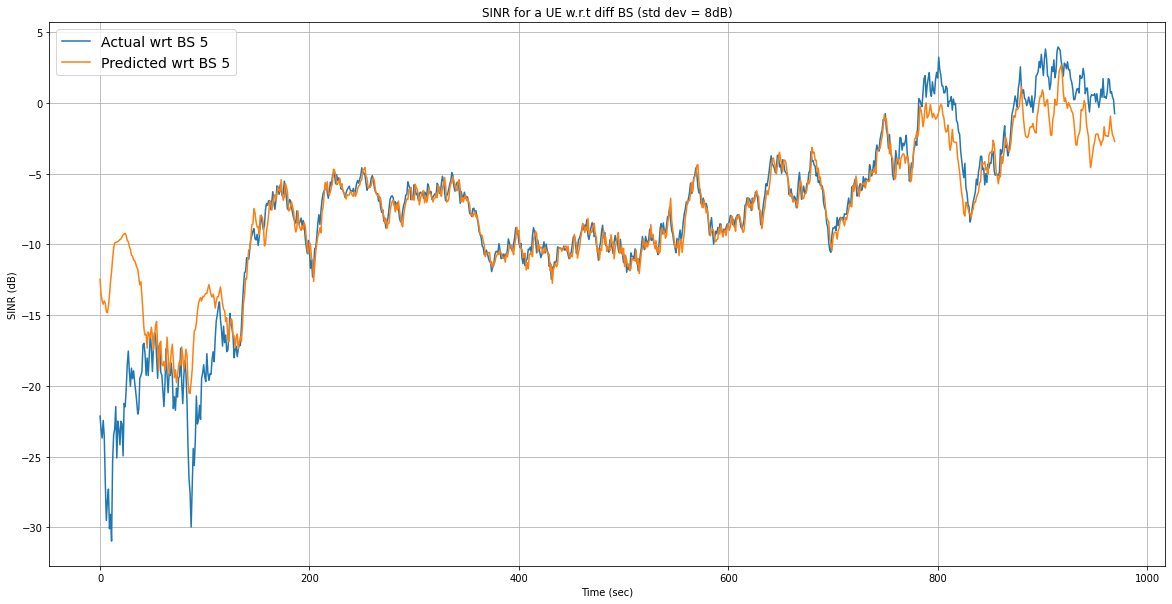

RMSE for SVR:  4.166997441796797
MAE FOR SVR: 3.004453599659306


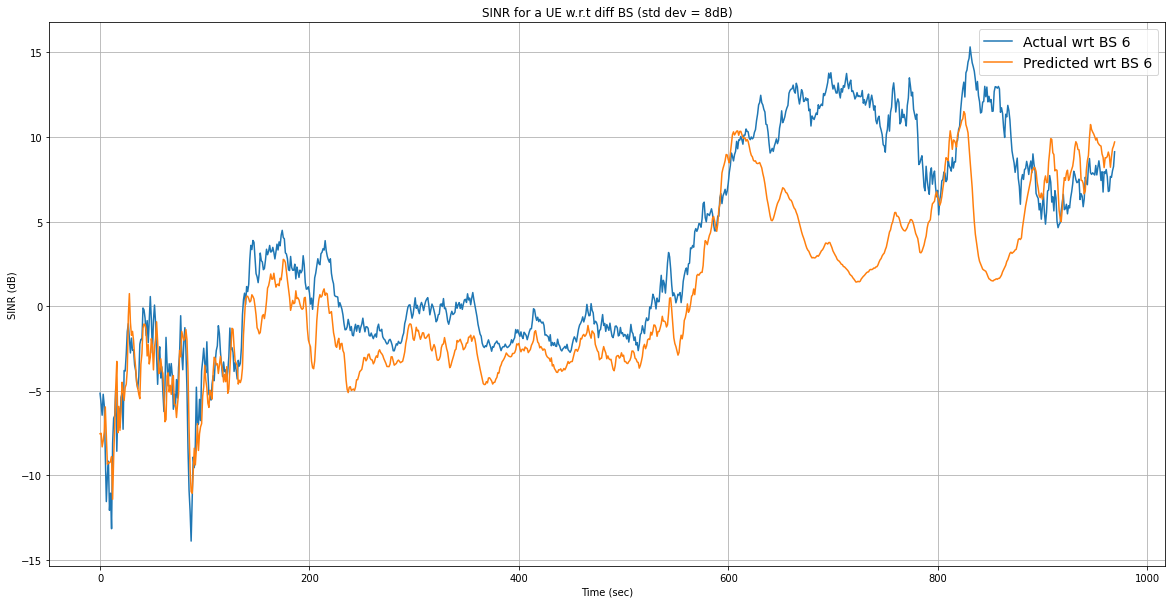

RMSE for SVR:  7.98297041918973
MAE FOR SVR: 4.406471855867779


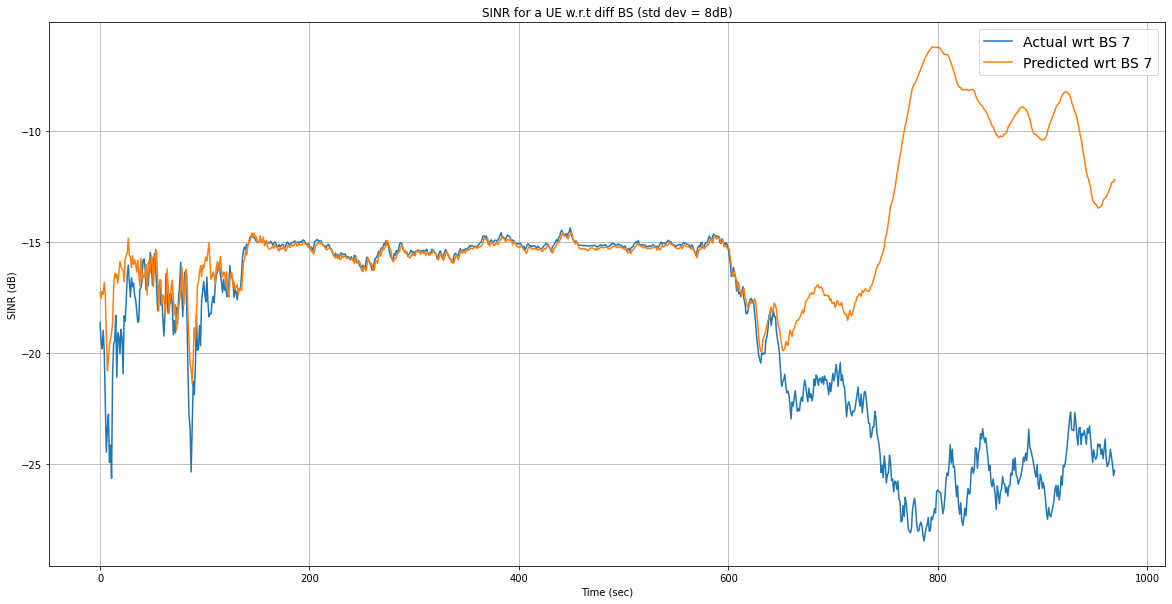

RMSE for SVR:  25.826800963810122
MAE FOR SVR: 23.40782332483029


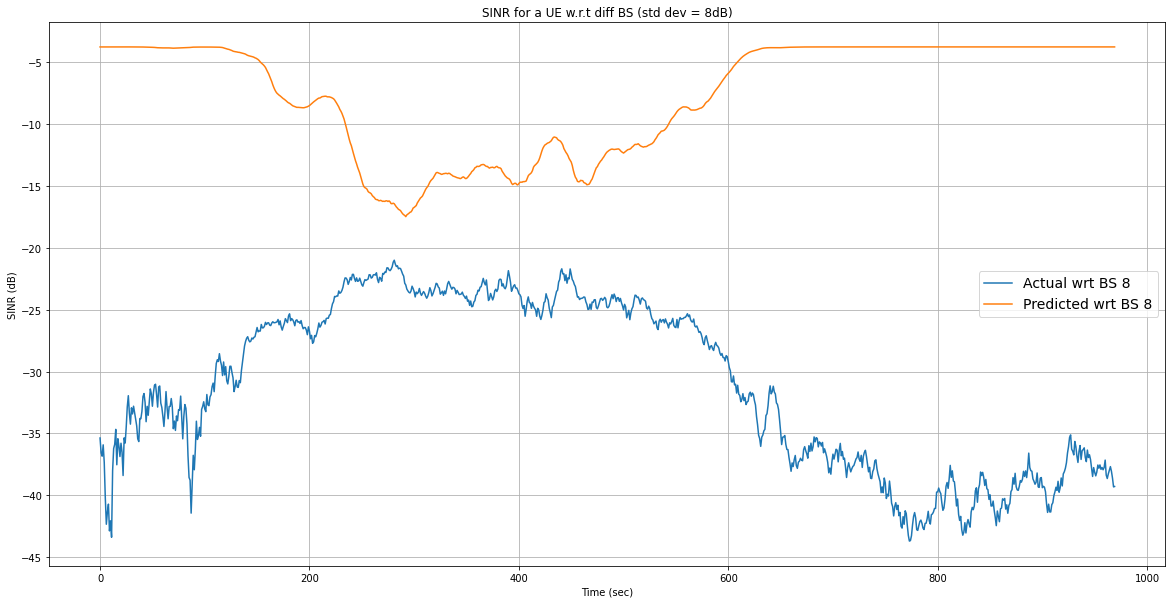

RMSE for SVR:  31.472885433866246
MAE FOR SVR: 31.020859701552563


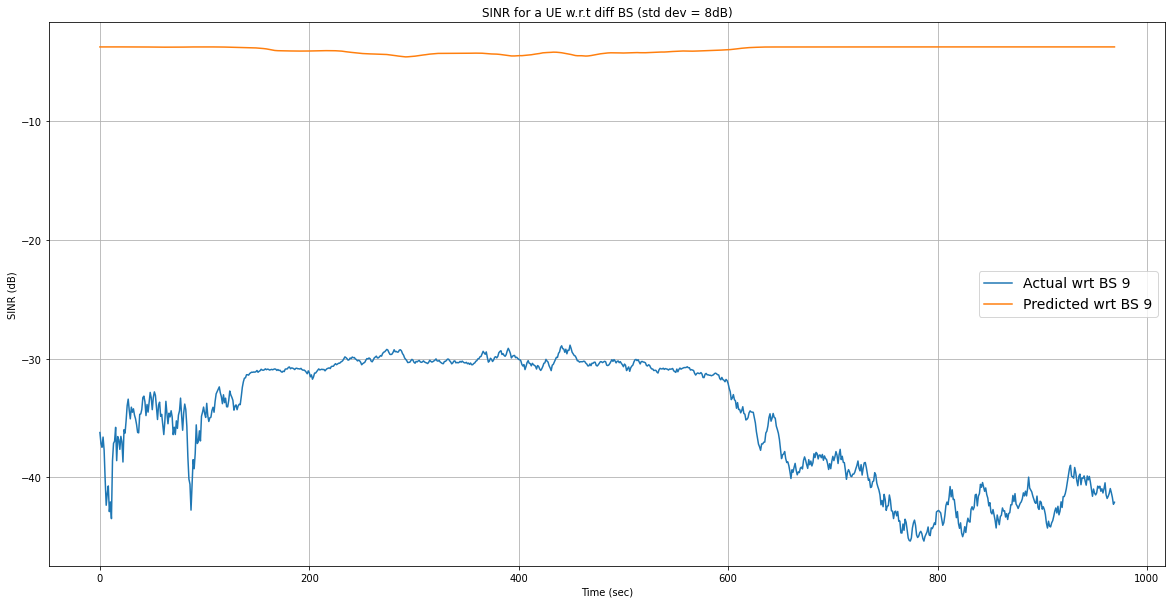

RMSE for SVR:  39.21615384493369
MAE FOR SVR: 39.15665657644637


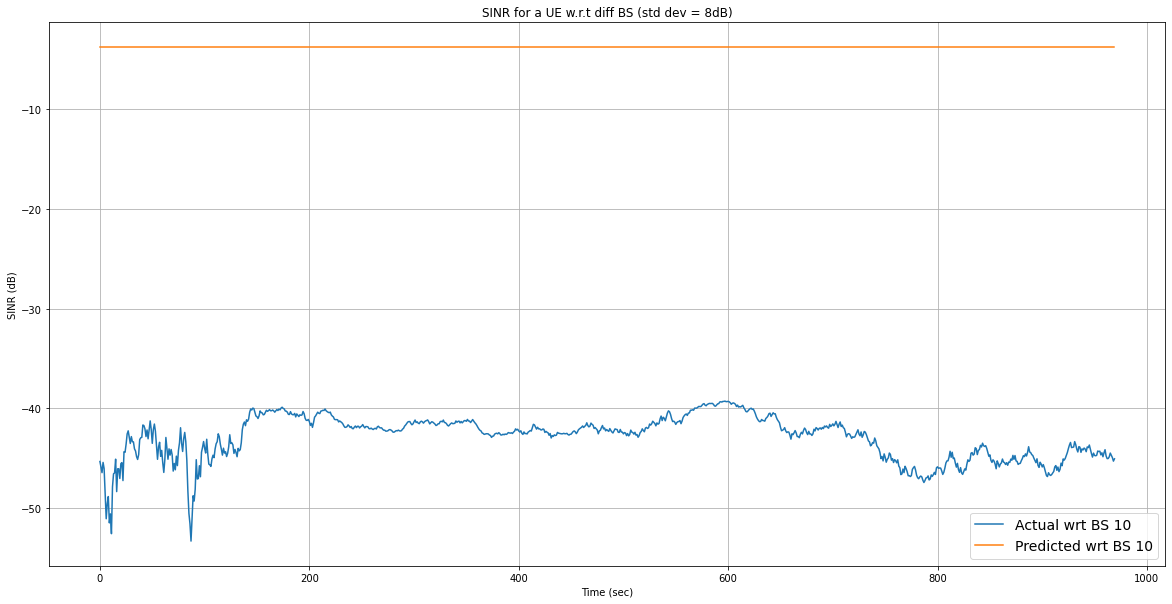

In [115]:
for i in range(0,10):
    test_dti = test_dt[:1000, i] #original
    
    testx, testy = window_dataset(test_dti, window_size)
    time_dti = np.arange(len(testy))
    
    testdti_forecast = svr_rbf.predict(testx)
    #print(testdti_forecast[:,0].shape)

    #print(time_dti.shape, test_dti[0:-1].shape)
    #print(time_dti[window_size:].shape, pred_yi.shape)
    
    print("RMSE for SVR: ", mean_squared_error(testy, testdti_forecast, squared=False))
    print("MAE FOR SVR:", mean_absolute_error(testy, testdti_forecast))
    #print(test_dti.shape)
    #print(testdti_forecast.shape)
    
    plt.figure(figsize=(20, 10))
    pred_yi = testdti_forecast  
    plot_series(time_dti, testy, std_dev =8, label="Actual wrt BS {}".format(i+1))
    plot_series(time_dti, pred_yi, std_dev = 8, label="Predicted wrt BS {}".format(i+1))
    plt.show()
    

# Gradient Boosted Regression Trees

In [56]:
#pip install xgboost

In [77]:
import xgboost as xgb

In [91]:
model=xgb.XGBRegressor(learning_rate =0.2,
 n_estimators=10)

In [92]:
print(x_train.shape, y_train.shape)

(7970, 30) (7970,)


In [95]:
print(x_test.shape, y_test.shape)

(1970, 30) (1970,)


In [96]:
moutput = model.fit(x_train, y_train)

In [97]:
moutput

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [123]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 10,
 'n_jobs': 16,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [98]:
xgboost_predictions = model.predict(x_test)

In [99]:
xgboost_predictions.shape

(1970,)

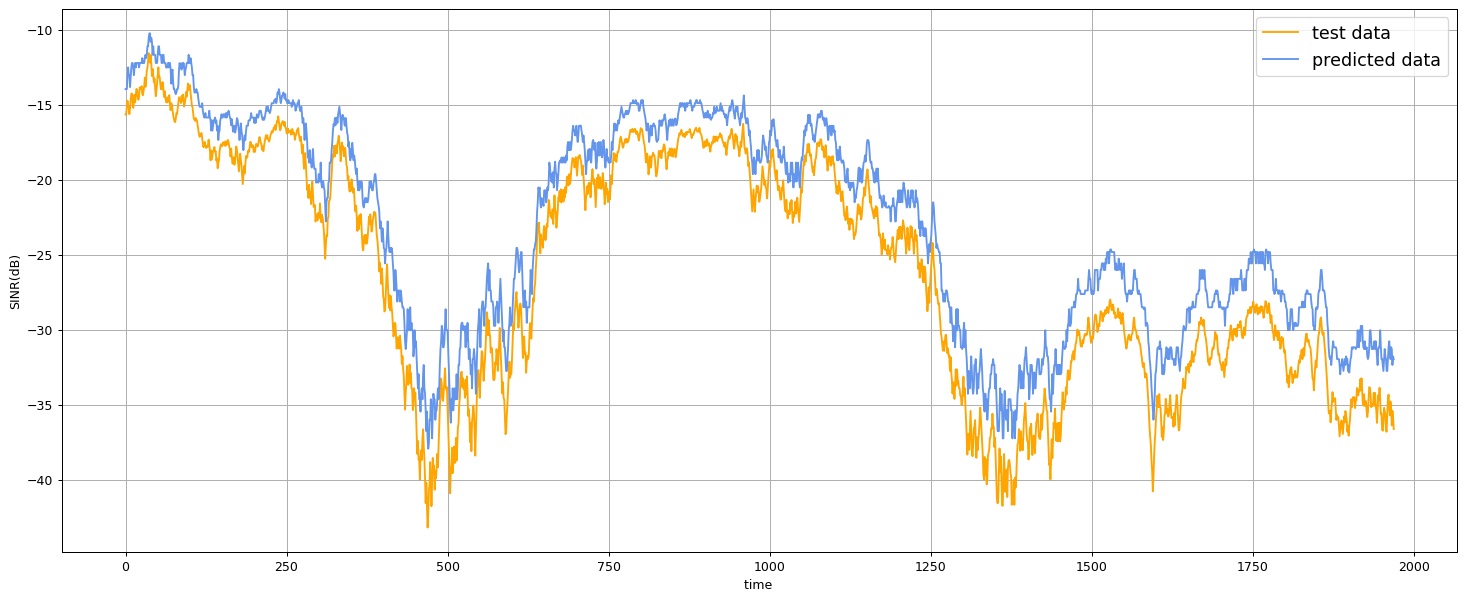

In [116]:
figure(figsize=(20, 8), dpi=90)
plt.plot(y_test, color='orange', label='test data')
plt.plot(xgboost_predictions, color='cornflowerblue', label='predicted data')

plt.legend(fontsize=14)
plt.xlabel("time ")
plt.ylabel("SINR(dB)")
plt.grid()
plt.show()

In [117]:
y_test.shape

(1970,)

In [121]:
xgboost_rmse_error = mean_squared_error(y_test, xgboost_predictions, squared= False)
xgboost_mae_error = mean_absolute_error(y_test, xgboost_predictions)
print(f'RMSE for GBRT: {xgboost_rmse_error:.4f}')
print(f'MAE for GBRT: {xgboost_mae_error:.4f}')

RMSE for GBRT: 3.0558
MAE for GBRT: 2.8822


RMSE for SVR:  2.1271630477367665
MAE FOR SVR: 1.878275234386332


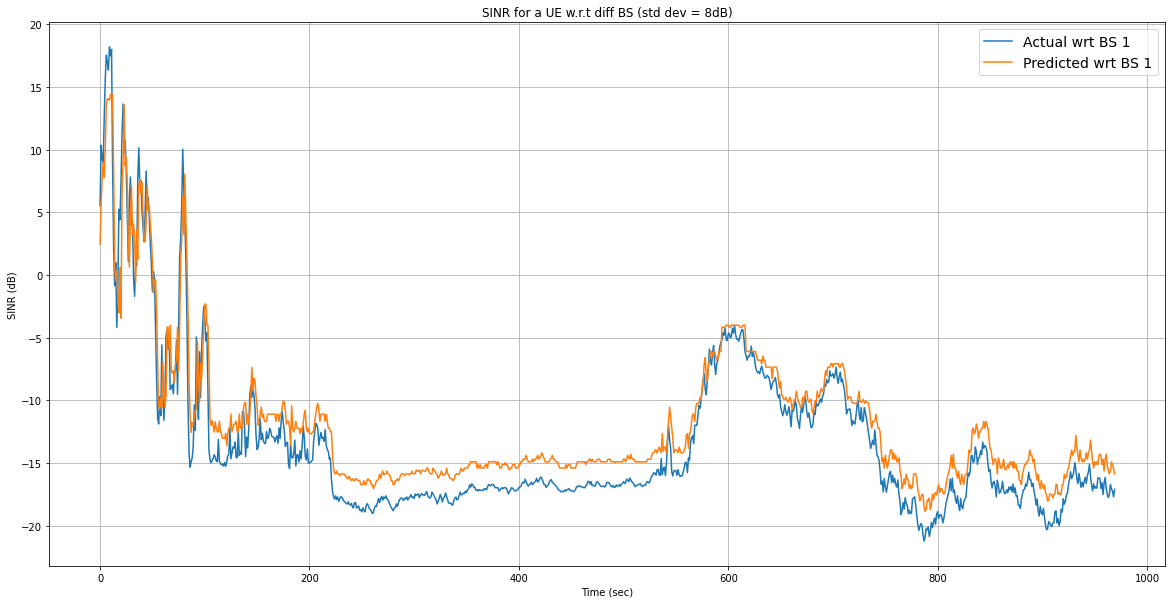

RMSE for SVR:  2.1414790072742513
MAE FOR SVR: 1.645237448828793


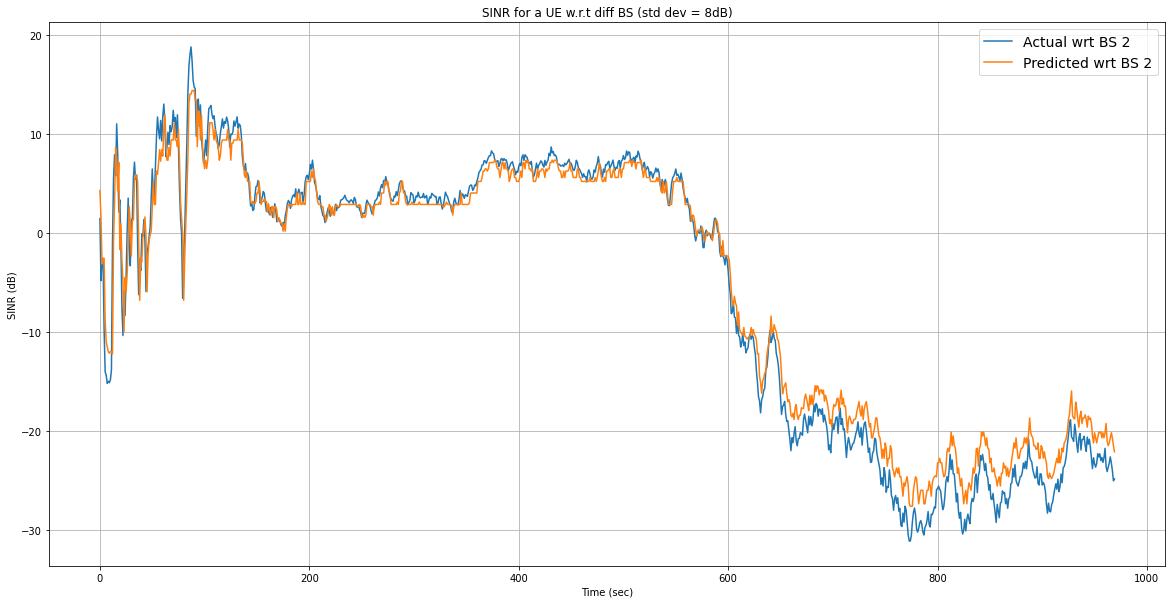

RMSE for SVR:  2.5056665071481175
MAE FOR SVR: 2.340202558718712


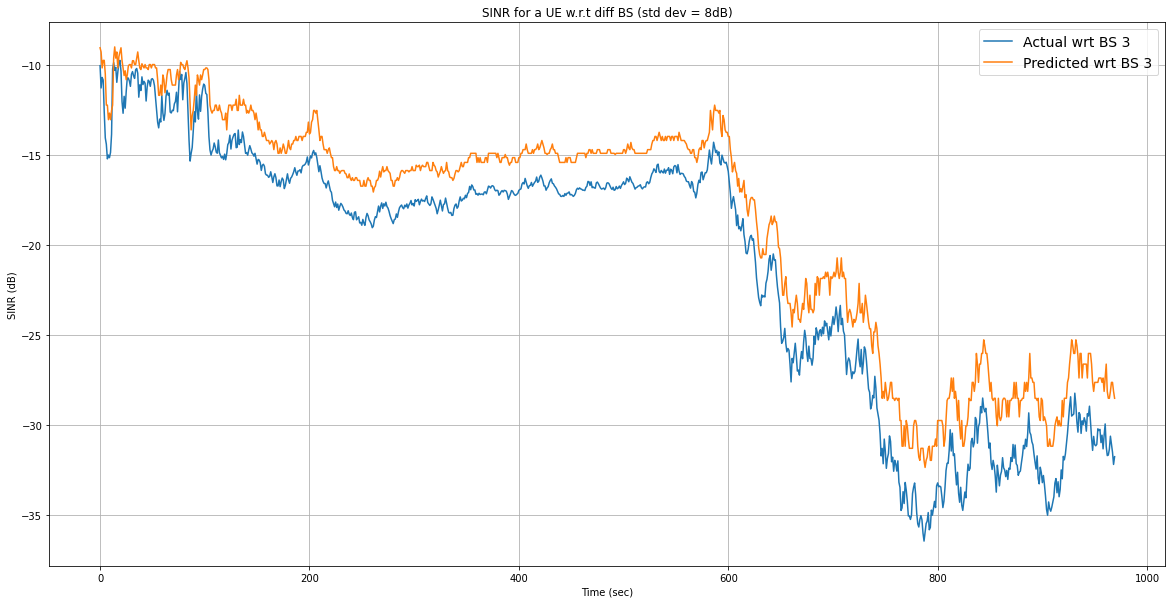

RMSE for SVR:  1.8205896574403326
MAE FOR SVR: 1.6352357993111093


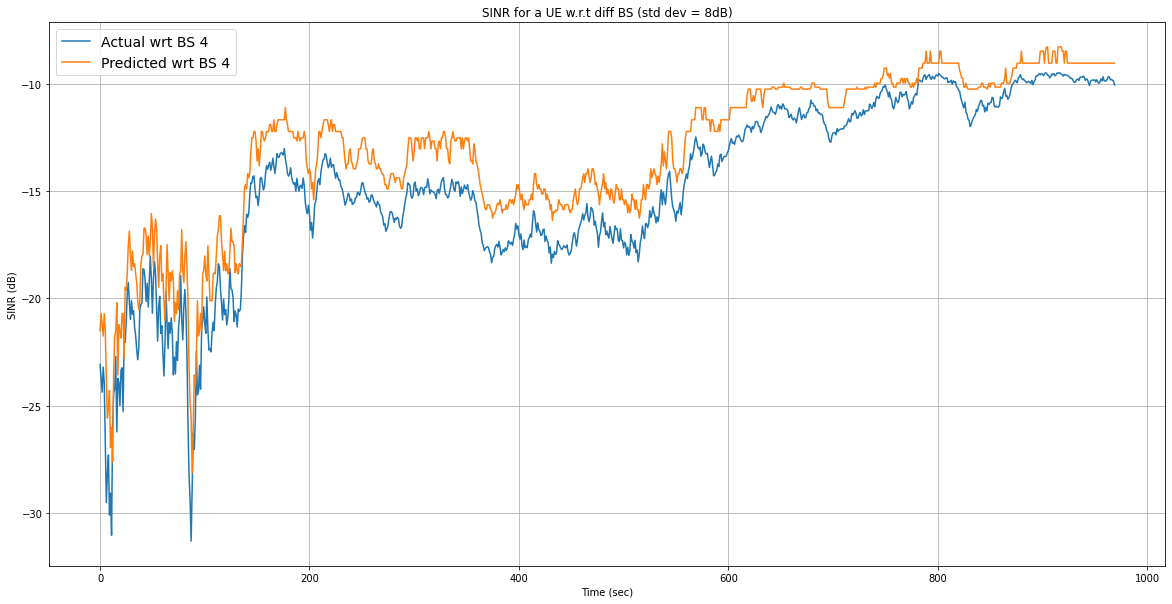

RMSE for SVR:  1.323977995267987
MAE FOR SVR: 0.9705618563514743


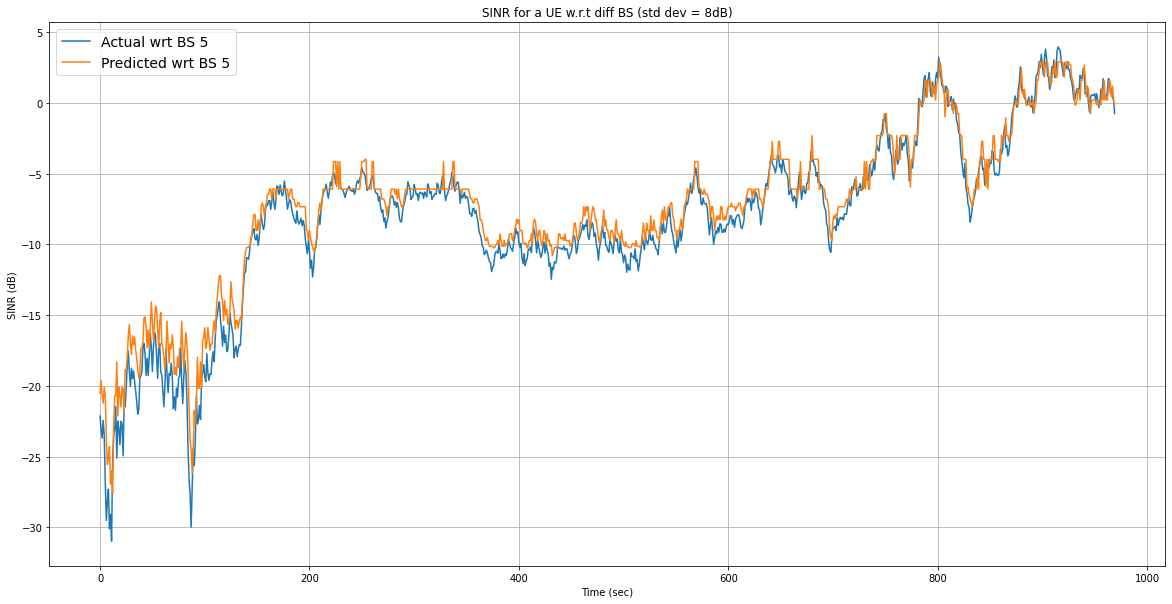

RMSE for SVR:  1.1154056927307363
MAE FOR SVR: 0.853746760914233


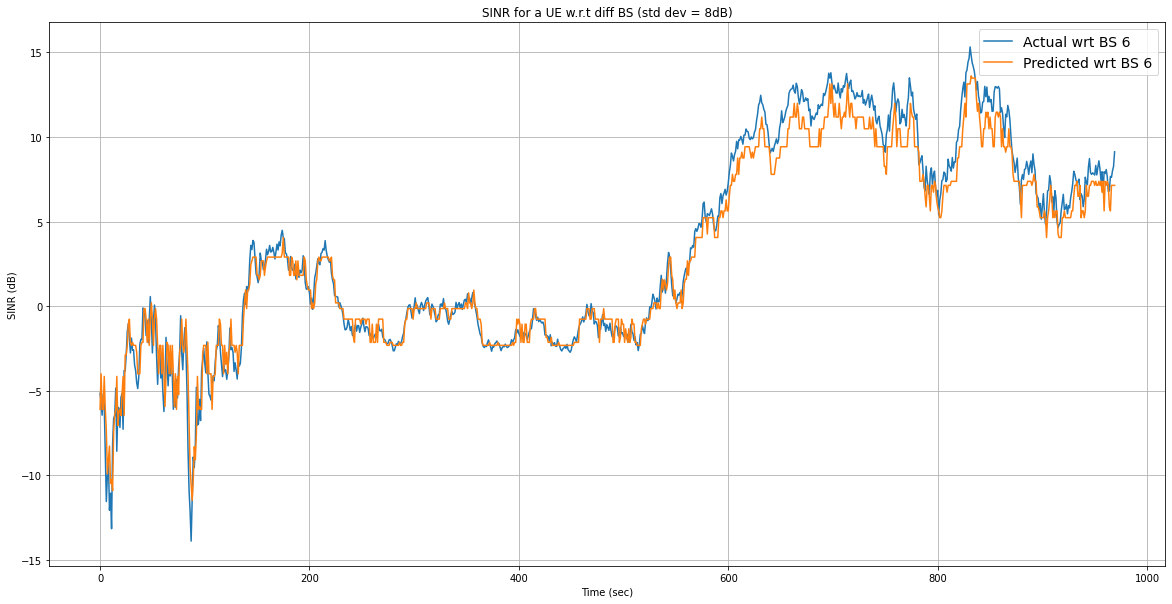

RMSE for SVR:  2.3433494595412094
MAE FOR SVR: 2.263116186173587


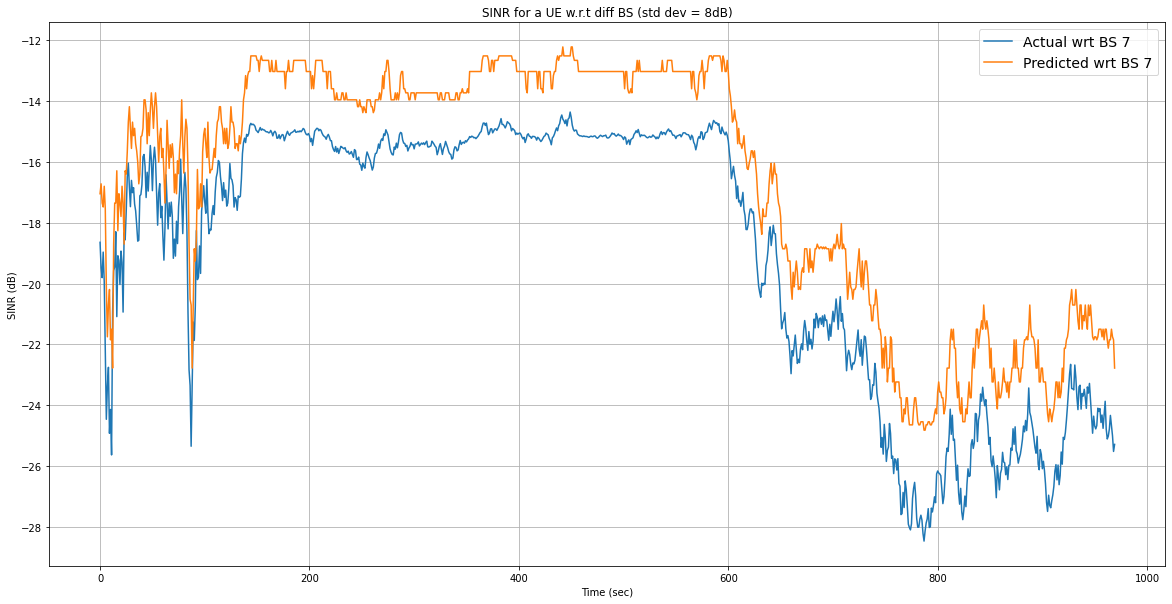

RMSE for SVR:  3.5440566149435337
MAE FOR SVR: 3.4027654942511223


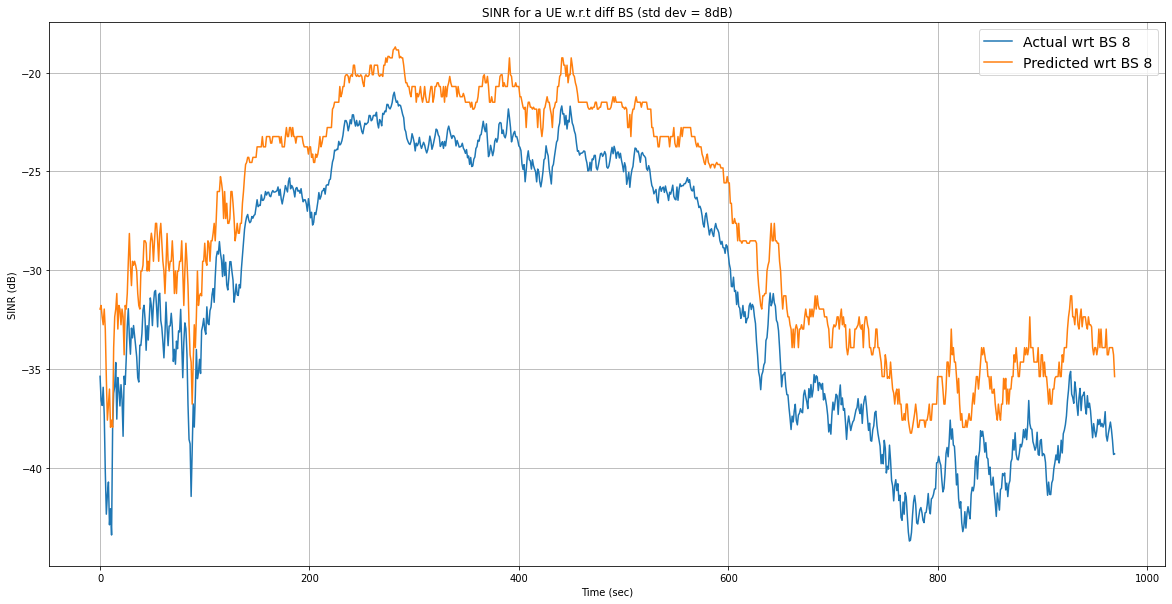

RMSE for SVR:  3.9762066568790204
MAE FOR SVR: 3.848786417775141


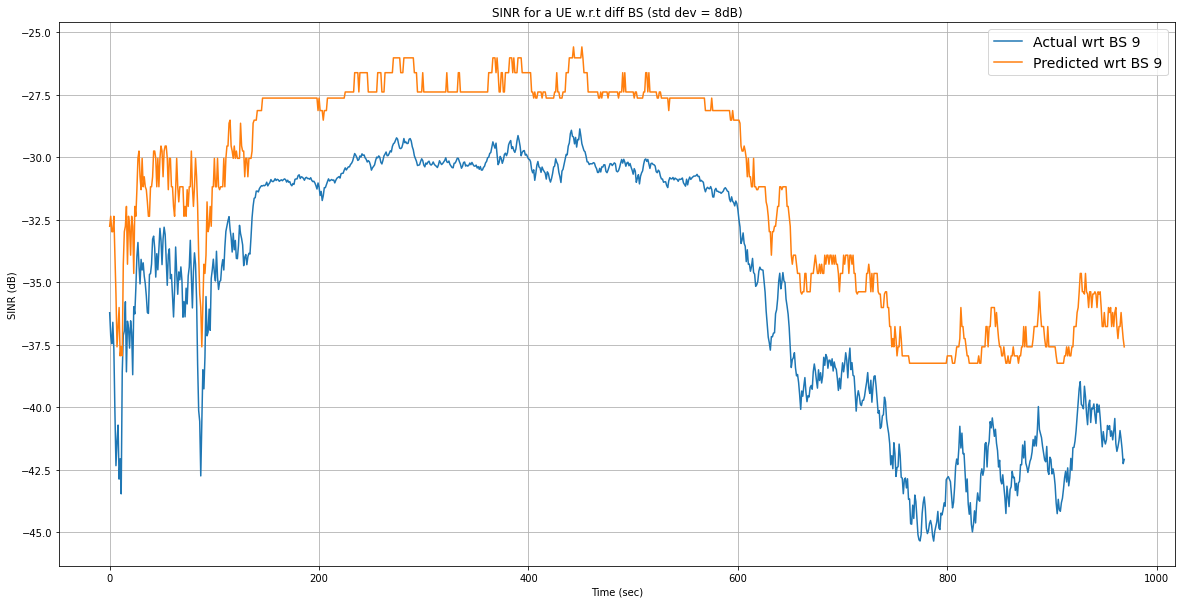

RMSE for SVR:  5.734805571712198
MAE FOR SVR: 5.535879141658372


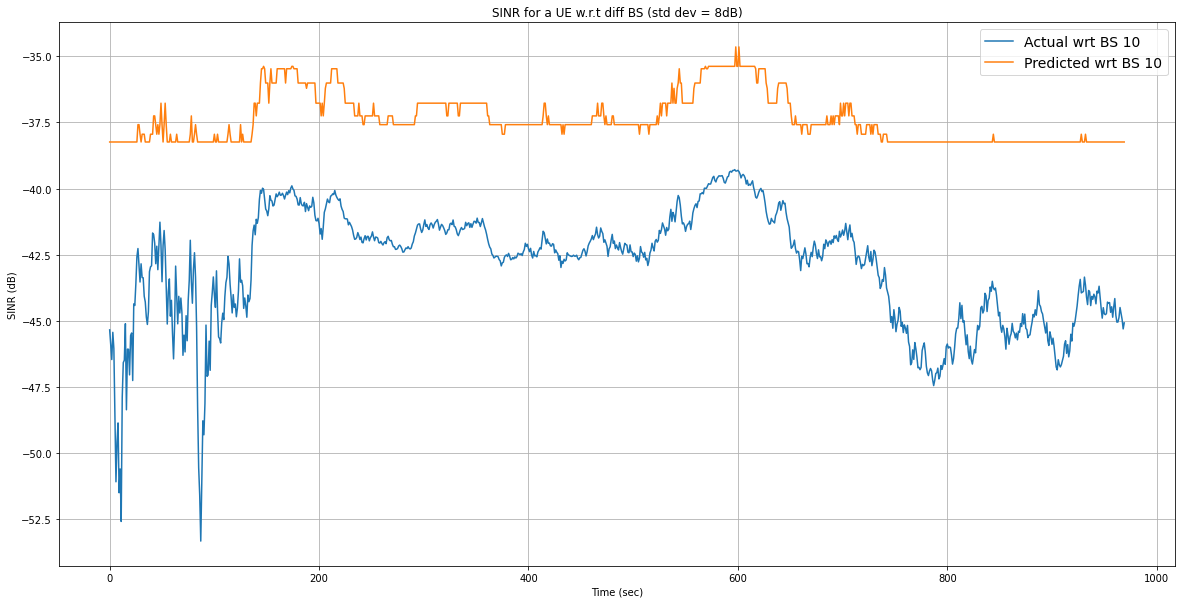

In [124]:
for i in range(0,10):
    test_dti = test_dt[:1000, i] #original
    
    testx, testy = window_dataset(test_dti, window_size)
    time_dti = np.arange(len(testy))
    
    testdti_forecast = model.predict(testx)
    #print(testdti_forecast[:,0].shape)

    #print(time_dti.shape, test_dti[0:-1].shape)
    #print(time_dti[window_size:].shape, pred_yi.shape)
    
    print("RMSE for SVR: ", mean_squared_error(testy, testdti_forecast, squared=False))
    print("MAE FOR SVR:", mean_absolute_error(testy, testdti_forecast))
    #print(test_dti.shape)
    #print(testdti_forecast.shape)
    
    plt.figure(figsize=(20, 10))
    pred_yi = testdti_forecast  
    plot_series(time_dti, testy, std_dev =8, label="Actual wrt BS {}".format(i+1))
    plot_series(time_dti, pred_yi, std_dev = 8, label="Predicted wrt BS {}".format(i+1))
    plt.show()
    

## Hyperparameter Tuning Using Random Search

In [136]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 6)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

print(random_grid)


{'n_estimators': [5, 10, 15, 20, 25, 30], 'max_depth': [5, 8, 11, 14, 17, 20, None]}


In [128]:
np.linspace(start = 5, stop = 30, num = 6)

array([ 5., 10., 15., 20., 25., 30.])

In [133]:
np.linspace(5, 20, num = 6)

array([ 5.,  8., 11., 14., 17., 20.])

In [137]:
rf = xgb.XGBRegressor()

In [138]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 30, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [139]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predicto

In [140]:
rf_random.best_params_

{'n_estimators': 15, 'max_depth': 5}